<a href="https://colab.research.google.com/github/nicolasrondan/cv-um-2023/blob/main/practico-4/Practico_4_Reconocimiento_de_Objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2023/practico-4/

# INSTALACION (SOLO EJECUTAR EN GOOGLE COLAB) 
***Importante*** *: El codigo de instalción hace que el entorno se reinicie, luego de reiniciar volver a todas las celdas (Incluso montar Google driver) para que los paquetes necesarios queden instalado correctamente.*

In [ ]:
#@title Installing condacolab (ONLY GOOGLE COLAB)
!pip install -q condacolab

In [ ]:
#@title install conda
import condacolab
condacolab.install()

In [ ]:
#@title check conda
import condacolab
condacolab.check()

In [ ]:
#@title install cyvlfeat
!conda install -c conda-forge cyvlfeat -y

# Introducción

En este práctico vamos a trabajar sobre los distintos algoritmos de reconocimiento de objetos y escenas vistos en clase. En particular vamos a clasificar imágenes de distintos tipos de escenas (Cocina, Dormitorio, Oficina, etc). Para ello vamos a utilizar dos representaciones de imágenes diferentes (Imágenes raw y Bag of Words basado en descriptores SIFT). A su vez se van a utilizar dos clasificadores KNN y SVM para clasificar las imágenes. Se  van a clasificar las 15 categorias de imágenes del articulo [Lazebnik et al 2006](https://inc.ucsd.edu/~marni/Igert/Lazebnik_06.pdf) y se va a implementar uno de los baselines utilizados en el articulo para clasificar imágenes (SIFT + BoW).


\**Este practico fue adaptado de un trabajo propuesto en el curso Image and Vision Computing de University of Edinburgh y originalmente diseñando por James Hays para Brown University.*

## Datos Entrenamiento

Los datos de entrenamineto de este practico los vamos a descargar de la siguiente manera utilizando el comando `gdown` para descargar los datos desde google drive. La ubicación final de los datos sera en la carpeta: 

`/content/sample_data/data`



In [ ]:
import gdown

In [ ]:
 file_id = '1Dp2_Vgx0gmj2haUOsQQPZWzrgyT5E-jn'
src_url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
output_file = '/content/sample_data/data.zip'
gdown.download(src_url, output_file, quiet=False,use_cookies=False)

In [ ]:
import shutil
output_folder = '/content/sample_data/'
shutil.unpack_archive(output_file, output_folder)

## Deep Learning
Luego de entrenar los clasificadores basados en extracción de features más clásicos vamos a trabaja en entrenar una red de aprendizaje profundo. Esto se hara en un notebook separado que está en la misma carpeta de este práctico.

## Configuración
Para la implementación de BoW y SIFT en la Parte 2 de este laboratorio vamos a utilizar el paquete vlfeat para Pyhton (www.vlfeat.org). Para instalarlo en google colab es necesario ejectutar el bloque de instalación en el encabezado del notebook. Si quieren instalarlo localmente en su computadora es recomendable usa conda un con un *virtualenv*. Para instalar vlfeat utilizar el siguiente comando dentro de su *virtualenv*.



```
conda install -c conda-forge cyvlfeat
```



# Parte1: Miniaturas de Imágenes y KNN

La primera parte consiste en implementar una versión simple del clasificador KNN. Para ello vamos a utilizar el código provisto en esta sección el cual ya tiene implementadas funciones para leer las imágenes de entrenamiento, convertirlas en miniaturas de 16x16 además una función para mostrar los resultados clasificación. Revisar este archivo y las funciones provistas, asegurarse de entender que es lo que se está haciendo en cada una de ellas.



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
from typing import List, Tuple
import pandas as pd

### Elegir los datos de training y testing:

1.   Vamos a utilizar una función para cargar nuestros datos de training y testing
2.   Estos datos van a quedar cargados en un [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) de pandas que nos permite consultar para cada imagen su ruta y archivo



In [ ]:
def generate_datasets(data_folder:str , categories:List[str], image_per_category:int)-> Tuple[pd.DataFrame]:
    """ Given a data folder extracts paths for training and testing images with their corresponding labeles

    Args:
        data_folder: Path of folder containing train and test images
        categories: List of categories to use load from data
        images_per_category: Number of images per category

    Returns:
        Two dataframes including image paths and labels for training and testing images
    """
    num_categories = len(categories) #number of scene categories.

    #Total entries (15 categories * 100 training and test examples each)
    train_image_paths = [] 
    test_image_paths  = []
    
    train_labels = []
    test_labels  = []

    for i in range(0,num_categories):
        
        images = sorted(glob(os.path.join(data_folder, 'train', categories[i], '*.jpg')))

        train_image_paths += images[:image_per_category]
        train_labels += [categories[i]]*image_per_category 
       
        images_test = sorted(glob(os.path.join(data_folder, 'test', categories[i], '*.jpg')))
    
        test_image_paths += images_test[:image_per_category]
        test_labels += [categories[i]]*image_per_category 
    
    train_df = pd.DataFrame({'image_path':train_image_paths,'category':train_labels})
    test_df = pd.DataFrame({'image_path':test_image_paths,'category':test_labels})
        
    return train_df, test_df

In [ ]:
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 
       'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
       'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub', 
    'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

In [ ]:
N_EXAMPLES = 50

In [ ]:
data_folder = '/content/sample_data/data'

In [ ]:
train_df, test_df = generate_datasets(data_folder,categories,N_EXAMPLES)

### Vamos a inspeccionar el contenido de los dataframes



In [ ]:
train_df.sample(10)

In [ ]:
train_df.describe()

In [ ]:
test_df.sample(10)

In [ ]:
test_df.describe()

### Representar cada imagen con features

In [ ]:
from tqdm import tqdm

In [ ]:
def image_to_thumbnail(image:np.ndarray,target_size=Tuple[int])->np.ndarray:
    """ Reescales image to a grayscale thumnail of the selected target size

    Args:
        image: input image to reescale
        target_size: desired output image size
    Returns:
        Grayscale image of the selected size
    """
    original_image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_image_gray_float = original_image_gray/255.
    thumbnail_image = cv2.resize(original_image_gray_float,dsize=target_size)

    return thumbnail_image

In [ ]:
def thumbnails_matrix(images_dataframe: pd.DataFrame, dataframe_column='image_path', target_size=16) -> np.ndarray:
    """ Creates a feature matrix based on vectorized image thumnails given a dataframe with image paths

    Args:
        image_dataframe: dataframe containing image paths and labels
        dataframe_column: dataframe column where image paths are stored
        target_size: target thumbnail image side, images will be resized to (target_size,target_size) shape

    Returns:
        Matrix with one feature vector per image encoded in each row
    """
    num_images = images_dataframe.shape[0]
    output_size = target_size 
    feature_matrix = np.zeros([num_images,output_size*output_size])

    for idx, image_file in tqdm(images_dataframe[dataframe_column].items(), total=num_images):
        
        original_image = cv2.imread(image_file)
        thumbnail_image = image_to_thumbnail(image=original_image,target_size=(output_size,output_size))
        feature_matrix[idx,:] = thumbnail_image.flatten()

    return feature_matrix

In [ ]:
#Step 1: Represent each image with a feature
print('Using Tiny images representation for images') 

train_matrix = thumbnails_matrix(train_df)
test_matrix  = thumbnails_matrix(test_df)


### Inspeccionemos la representación de imagenes que vamos a utilizar:
Comparemos la imagen original contra la imagen thumnail y su vector de representación


In [ ]:
image_path = train_df.iloc[0]['image_path']
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_thumbnail = image_to_thumbnail(image,target_size=(16,16))
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(image_rgb)
plt.title('original image')
plt.subplot(122)
plt.imshow(image_thumbnail,cmap='gray')
plt.title('image thumbnail')

In [ ]:
image_vector = image_thumbnail.reshape(1,-1)
plt.figure(figsize=(15,3))
plt.imshow(image_vector,cmap='gray')
plt.show()

## Entrenar Clasificadores


Pasos:
1. ***Implementar Clasificador:***
Una vez extraída la representación de las imágenes (`thumbnails_matrix`) es necesario implementar un clasificador KNN en la funcion nearest_neighbour esta función tiene como parámetros un array $ N \times D $ de imágenes de entrenamiento (`train_matrix`), una lista de N elementos conteniendo las etiquetas de entrenamiento (`train_labels`) y un array de $ M \times D $ conteniendo las imágenes a clasificar (`test_matrix`). La salida debe ser una lista (`predicted_labels`) de tamaño M conteniendo las predicciones de etiquetas para las imágenes de testing.
2. ***Evaluar Algoritmo:***
Una vez hechas las predicciones la función `create_results_webpage` evalua el algoritmo al comparar las predicciones contra las etiquetas reales de las imágenes de testing (esto se denomina **Ground Truth (GT)**). En esta evaluación vamos a reportar el ***Accuracy*** total del algoritmo y la matriz de confusión entre clases. También se van a mostrar algunas predicciones de ejemplo que realiza el algoritmo. 



### Matriz de confusión

Una matriz de confusión muestra las distintas clases y el porcentaje de errores de clasificación de cada clase con cada una de las otras clases posibles. Un ejemplo de la salida se puede visualizar en la siguiente figura, donde se ve que para el caso de escenas de una autopista (Highway) clasifica correctamente en el **64 %** de los casos.

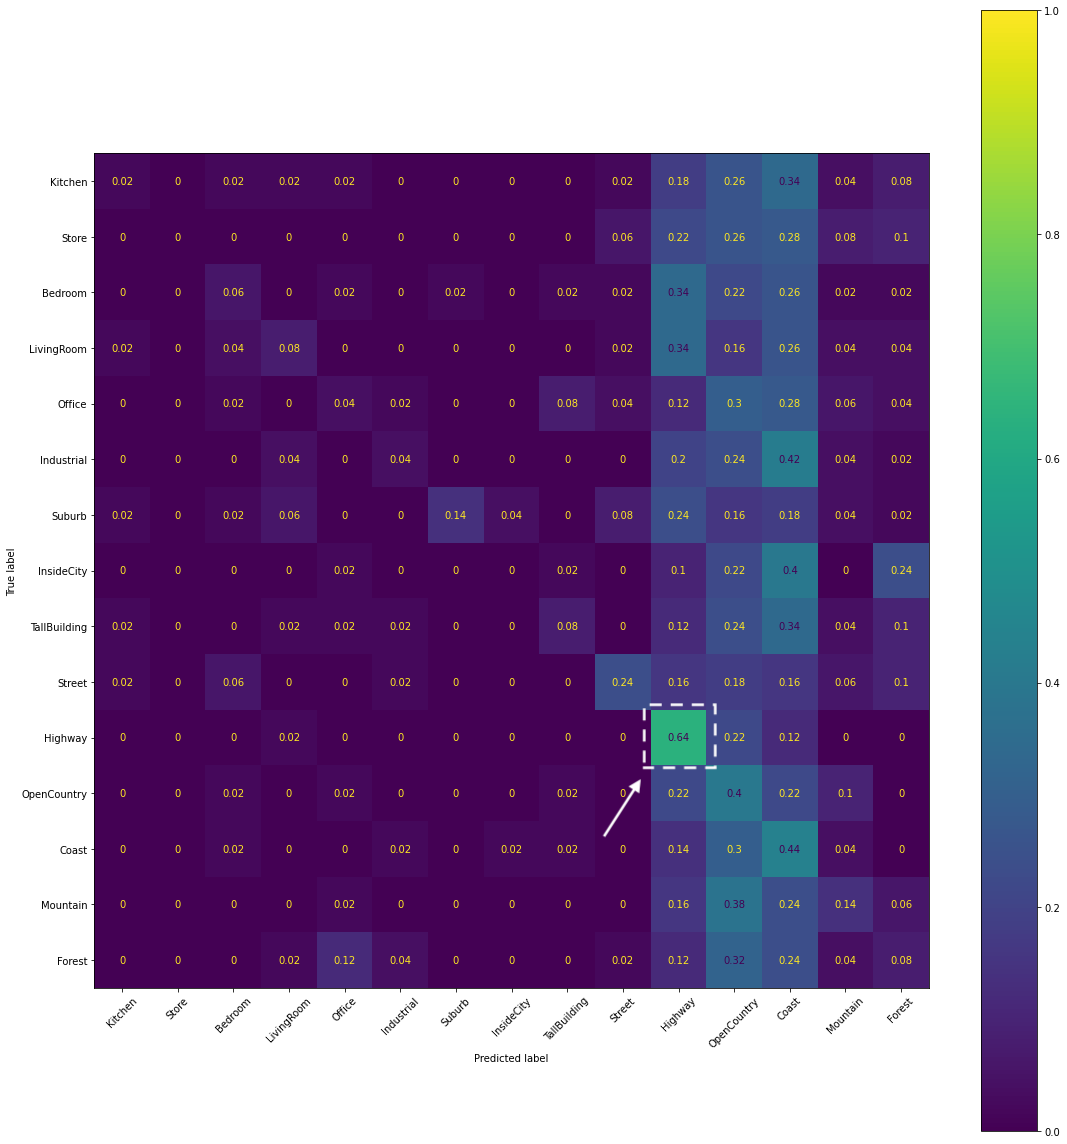


***Como interpretar los resultados***: Para el caso de NN sencillo (1-NN) el accuracy final de la clasificación es 16%. Si bien no es un buen resultado es bastante mejor que utilizar un clasificador random donde el accuracy debería ser 1/15 = 6,6 %

***Hint 1***: Se puede utilizar la función de [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) de Scipy que hace la mayoría del trabajo al implementar el algoritmo de KNN. Otras funciones útiles son min(), [argsort](https://www.kite.com/python/docs/numpy.argsort), unique(). Implementar primero 1-NN y luego extenderlo a KNN.

Una vez implementado el algoritmo se pueden utilizar más datos de entrenamiento para mejorar el Accuracy modificando la variable `N_EXAMPLES`
. 

**[Opcional]** 
Probar si los resultados finales varían al hacer alguna de las siguientes mejoras:
1. Modificar el tamaño del thumbnail utilizado para representar una imagen. 
2. Estandarizar los datos antes de clasificar (función [normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize)). 
3. Utilizar otras distancias que no sean la Euclidiana para comparar la representación dos imágenes.

In [ ]:
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from scipy.stats import mode

In [ ]:
def nearest_neighbour(train_matrix:np.ndarray, train_labels:List[str], test_matrix:np.ndarray,k:int) -> List[str]:
    """ Classifies test examples using a K-NN classifier based on the training data.

    Args:
        train_matrix: training matrix contatining training vectors
        train_labels: label for each of the training points
        test_matrix: test matrix contating testing vectors which need to be classified
        k: K value defining the number of nearest neighbours which will be used to classify a point
    Returns:
        A list of labels containing the classification label for each of the testing data points
    """
    print('\n nearest neighbor classifier\n')

    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    categories = list(le.classes_)
    num_categories = len(categories) 

    test_labels = []
    
    return test_labels

In [ ]:
train_labels = train_df['category'].values
test_labels = test_df['category'].values
train_image_paths = train_df['image_path']._values
test_image_paths = test_df['image_path'].values

In [ ]:
#Step 2: Classify each test image by training and using the appropriate classifier
print('Using Nearest Neighbor classifier to predict test set categories')
k=1  # the K nearest neighbor
predicted_labels_knn = nearest_neighbour(train_matrix, train_labels, test_matrix,k)  

In [ ]:
from web_page import create_results_webpage

In [ ]:
html = create_results_webpage(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, predicted_labels_knn)

In [ ]:
import IPython
from google.colab import output

display(IPython.display.HTML(html))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
knn_accuracy = accuracy_score(test_labels,predicted_labels_knn)

In [ ]:
np.save('predicted_labels_knn',predicted_labels_knn)

# Parte 2: SIFT BOW con clasificador SVM

La segunda parte consiste en implementar una versión simple del algoritmo _bag of words_ o _bag of features_ basado en descriptores SIFT y entrenar un clasificador SVM para clasificar imágenes. Para ello se probee el siguiente esqueleto de còdigo. 

Es necesario implmentar las funciones `codebook` que crea el vocabulario visual y la función `bag_of_words` que extrae la representación de una imagen con el algoritmo visto en clase.

## Construir el CodeBook
En la función codebook se pide armar le vocabulario visual realizando los siguientes pasos:
1. Iterar sobre los image path de las imágenes de entrada para cargar cada imagen y llamar una función que extraiga puntos SIFT con sus descriptores. Vamos a utilizar la implementación de SIFT para python de vl_feat en la cual se pueden obtener keypoints y descriptores utilizandos las funciones `sift` y `dsift`(dense sift). (*hint:* es recomendable hacer blur antes de calcular descriptores sift.)
2. Agrupar todos los descriptores en una matriz y armar clusters de datos con una rutina k-means se puede utilizar la implementación de scikit-learn de [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Finalmente utilizar el parámetro `num_words` para cambiar el numero de palabras en el diccionario visual.

\**Hint 1: Para hacer debbuging mientras se implementa el algoritmo se pueden utilizar menos imágenes de entrenamiento y menos palabras en el diccionario. Una vez implementado correctamente el algoritmo se pueden modificar estos parámetros para utilizar más datos y más palabras en el diccionario. El algoritmo puede demorar algunos minutos en entrenarse.*

\**Hint 2: Para acelerar el proceso de evaluar el algoritmo k-means es posible utilizar el algoritmo [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) provisto por scikit-learn*



In [ ]:
from cyvlfeat.sift import sift, dsift
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [ ]:
def codebook(image_paths:str,number_of_words:int) -> np.ndarray:
    """ Builds a codebook of with a desired number of words based on SIFT 
    descriptors. The codebook is build by extracting dense sift descriptors for 
    each input image and clustering this descriptors in the desired number of 
    clusters defined by the number of words. The codebook is composed by the 
    center of the clusters.

    Args:
        image_paths: List of image paths to process and generate the codebook.
        number_of_words: number of words that the codebook will contain.
    Returns:
        An array of words that define the codebook. This words are the center of
        the clusters defined by the SIFT descriptors of all the images in the 
        dataset.
    """
    print('Extracting image features')
    # Add your own code in this section this is a dummy dictionary
    dictionary = np.zeros([number_of_words,1])
    print('finish building vocaulary')
    return dictionary

In [ ]:
if not os.path.exists('vocabulary.npy'):
  print('No existing visual word vocabulary found. Computing one from training images')

  number_of_words = 800; #Larger values will work better (to a point) but be slower to compute

  vocabulary = codebook(train_image_paths, number_of_words)
  np.save('vocabulary', vocabulary)

In [ ]:
vocabulary = np.load('vocabulary.npy')

## Utilizar el diccionario visual para representar una imagen como Bag of Words


En la función `bag_of_words` se deben leer las imágenes nuevamente y codificarlas utilizando el *codebook* o vocabulario visual entrenado previamente. Para hacer esto se puede seguir el siguiente procedimiento:

1. Extraer features para cada imagen utilizando el mismo extractor de features que en el codebook(ej. `dsift` extrae keypoints y los representa con descriptor de 128 bytes).
2.  Proyectar los descriptores a las palabras del diccionario visual (Se puede utilizar las funcion [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) más la función min para hacer esto).
3. Codificar las imágenes en un histograma de palabras visuales (Se puede utilizar la funcion [histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) de numpy). Es recomendable normalizar el histograma.


Una vez hecho esto, la función `bag_of_words` debe retornar una matriz de tamaño *N × num_of_words* conteniendo el histograma BoW para cada una de las N imágenes.

In [ ]:
def bag_of_words(image_paths:str, codebook:np.ndarray) -> np.ndarray:
    """ Builds a feature matrix based on a bag of word algorithm using the 
    desired codebook. The feature refresentation is defined by a histogram of 
    visual words present on the image. These visual words are defined by the 
    codebook.

    Args:
        image_paths: List of image paths to generate the feature matrix.
        codebook: pretrained codebook containing visual words.
    Returns:
        A matrix contaning the feauter representation of each image based on the
        selected codebook.
    """
    word_lenght = codebook.shape[1]
    vocabulary_size = codebook.shape[0]
    print('bags of words')
    number_of_images = len(image_paths)
    container = []
    image_features = np.zeros([number_of_images,vocabulary_size])

    ### YOUR CODE 

    return image_features

In [ ]:
train_image_features = bag_of_words(train_image_paths,vocabulary)
test_image_features  = bag_of_words(test_image_paths,vocabulary)

## Clasificar utilizando un SVM


El código para entrenar el clasificador SVM ya está implementado aunque los estudiantes pueden modificarlo si desean. El código utiliza la función vl_ svmtrain para entrenar y testear el clasificador SVM dependiendo de los para ́metros que se le pasen. El siguiente co ́digo sirve para evaluar las im ́agenes de test:

In [ ]:
from sklearn.svm import LinearSVC


In [ ]:
def svm(train_image_matrix:np.ndarray, train_labels:List[str], test_image_matrix:np.ndarray)->np.ndarray:
    """ Trains an SVM configured on default parameters based on the trainin features
    and training labels and clasifies the test images and returs predicted labels

    Args:
    train_image_matrix: matrix of image features to train SVM
    train_labels: labels associated with training data for learning supervision
    test_image_matrix: test image features to be classified by the trained SVM
    Returns:
    A matrix test labels predicted by the trained classifier
    """

    C_factor = 0.001 # Regularization
    classifier = LinearSVC(C=C_factor, multi_class='ovr')
    print('svm training started ')

    classifier.fit(train_image_matrix, train_labels)
    print('svm training finished ')

    predictions = classifier.predict(test_image_matrix)

    return predictions


In [ ]:
predicted_labels_bow = svm(train_image_features,train_labels,test_image_features)

In [ ]:
html = create_results_webpage(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, predicted_labels_bow)

In [ ]:
import IPython

display(IPython.display.HTML(html))

In [ ]:
bow_accuracy = accuracy_score(test_labels, predicted_labels_bow)

In [ ]:
np.save('predicted_labels_bow',predicted_labels_bow)

## Comparar Clasificadores

In [ ]:
classifer_names = ['KNN', 'BAG OF WORDS']
classifer_results = [f'{knn_accuracy*100:.2f}%', f'{bow_accuracy*100:.2f} %']
results_df = pd.DataFrame(data={'Classifier':classifer_names, 'Test Acc':classifer_results})

In [ ]:
results_df

##  Resultados Finales


El código para entrenar el clasificador SVM ya está implementado aunque los estudiantes pueden modificarlo si desean. El código utiliza el modelo [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) de scikit-learn para entrenar y testear el clasificador SVM. 

Como el clasificador SVM es lineal en este caso se entrenan 15 1-vs-rest clasificadores (esto se hace automáticamente al pasarle al clasificador el parametrod `multi_class='ovr'`). El SVM utiliza un parámetro de regularización C, se puede seleccionar el valor manualmente o utilizando un algoritmos del tipo grid-search para buscar un valor más óptimo.

**Resultados Esperados**: En este caso una implementación simple de SIFT BoW + SVM utilizando `dsift` debe estar cerca de 22% de Accuracy.

**[Opcional]** En el [articulo original](https://inc.ucsd.edu/~marni/Igert/Lazebnik_06.pdf) presentado en 2006 los autores reportan alrededor de un 70% de Accuracy. Para ello es necesario afinar todas las partes del pipeline del algoritmo. Optimizar la extracción de features SIFT, optimizar el vocabulario visual y optimizar la regularización del SVM. Buscar en el árticulo original los parámetros necesarios para llegar al nivel de Accuracy señalado.
